Let's train a model for predicting IMDb Reviews and see how it does on our tweets (which have been self classified). If it does well, I would rather use this since it has been verified by more users.

In [3]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#reading csv files
train = pd.read_csv('/content/drive/MyDrive/UHP 195/Train.csv')
valid = pd.read_csv('/content/drive/MyDrive/UHP 195/Test.csv')             

#train_test split
x_tr, y_tr = train['text'].values, train['label'].values
x_val, y_val = valid['text'].values, valid['label'].values


#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)


In [ ]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/UHP 195/crawl-300d-2M-subword.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2000000 word vectors.


In [ ]:

#embedding layer
size_of_vocabulary=len(tokenizer.word_index) + 1 
embedding_matrix = np.zeros((size_of_vocabulary, 300))

none_vals = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        none_vals+=1
print(none_vals/size_of_vocabulary)

0.36692987772271934


In [ ]:

model=Sequential()

model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('/content/drive/MyDrive/UHP 195/best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          33661200  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 33,889,169
Trainable params: 227,969
Non-trainable params: 33,661,200
_________________________________________________________________
None


In [ ]:
history = model.fit(np.array(x_tr_seq),np.array(y_tr),batch_size=128,epochs=10,validation_data=(np.array(x_val_seq),np.array(y_val)),verbose=1,callbacks=[es,mc])

Epoch 1/10
313/313 [==============================] - 78s 243ms/step - loss: 0.5928 - acc: 0.6600 - val_loss: 0.3896 - val_acc: 0.8232

Epoch 00001: val_acc improved from -inf to 0.82320, saving model to /content/drive/MyDrive/UHP 195/best_model.h5
Epoch 2/10
313/313 [==============================] - 78s 249ms/step - loss: 0.3900 - acc: 0.8261 - val_loss: 0.3671 - val_acc: 0.8370

Epoch 00002: val_acc improved from 0.82320 to 0.83700, saving model to /content/drive/MyDrive/UHP 195/best_model.h5
Epoch 3/10
313/313 [==============================] - 82s 262ms/step - loss: 0.3489 - acc: 0.8462 - val_loss: 0.3370 - val_acc: 0.8586

Epoch 00003: val_acc improved from 0.83700 to 0.85860, saving model to /content/drive/MyDrive/UHP 195/best_model.h5
Epoch 4/10
313/313 [==============================] - 79s 253ms/step - loss: 0.3232 - acc: 0.8585 - val_loss: 0.3204 - val_acc: 0.8626

Epoch 00004: val_acc improved from 0.85860 to 0.86260, saving model to /content/drive/MyDrive/UHP 195/best_mode

In [48]:
model = keras.models.load_model('/content/drive/MyDrive/UHP 195/best_model.h5')

In [8]:
trump_tweets = pd.read_csv("/content/drive/MyDrive/UHP 195/Trump_Tweets_Election.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
en_only = trump_tweets[trump_tweets['language'] == 'en']

In [12]:
import matplotlib.pyplot as plt


In [11]:
times = en_only[en_only['date'] == '2020-11-03']['time']

In [37]:
times

2          15:59:59
3          15:59:59
4          15:59:59
5          15:59:59
6          15:59:59
             ...   
1210718    00:00:00
1210720    00:00:00
1210721    00:00:00
1210722    00:00:00
1210723    00:00:00
Name: time, Length: 960224, dtype: object

In [15]:
from collections import Counter
time_count = Counter(times)

In [47]:
for row in en_only.iterrows():
  print(row)
  break

(2, id                                               1323776973500485635
conversation_id                                  1323776973500485635
created_at                                   2020-11-03 15:59:59 PST
date                                                      2020-11-03
time                                                        15:59:59
timezone                                                        -800
user_id                                          1075255497186598917
username                                               silvermancena
name                                                     HaveMoiiicy
place                                                            NaN
tweet              My wife wants to leave the country if Trump wi...
language                                                          en
mentions                                                          []
urls                                                              []
photos                        

In [32]:
new_map = {}
for time in time_count:
  minute = int(time[:2])*60 + time[3:5]
  if minute not in new_map:
    new_map[minute] = time_count[time]
  else:
    new_map[minute] += time_count[time]

x = []
y = []
for key in new_map:
  x.append(key)
  y.append(new_map[key])

In [41]:
en_only['date'][2]

'2020-11-03'

In [42]:
import datetime
date_time_str = en_only['date'][2] + ' ' + en_only['time'][2]
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
date_time_obj

datetime.datetime(2020, 11, 3, 15, 59, 59)

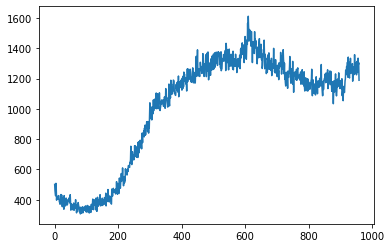

In [33]:
plt.plot(x,y)

In [ ]:
trump_tweets['tweet'].values.astype(str)

array(['Ganará Trump 🤔🧐🧐#Elecciones2020 #ElectionDay #ElectionNight #Elections2020  https://t.co/xyAeYwP9aE',
       'deus permita trump perder hoje',
       'My wife wants to leave the country if Trump wins, like for real. This is fucking crazy',
       ...,
       '🇺🇸 Trump clama a las madres de familia para ser reelegido: "¡Tengo que gustaros!"    https://t.co/imP6XaRZjY',
       'Lil Wayne met with President Trump on Thursday, praising his efforts in the black community.   https://t.co/ctFR43sORe',
       'MGAWEEN - Trump supporters hit the streets with no treats for Crooked Joe and his ho  https://t.co/aDkedoMRfd  #JustPlainPolitics'],
      dtype='<U1014')

In [51]:
en_only

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
2,1323776973500485635,1323776973500485635,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,1075255497186598917,silvermancena,HaveMoiiicy,NaN,My wife wants to leave the country if Trump wi...,en,[],[],[],0,0,4,[],[],https://twitter.com/SilvermanCena/status/13237...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1323776973336944641,1323763421813313539,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,60075654,iamkevinmckee,Kevin McKee,NaN,@DCoulbourne @jesseleite85 @jackmcdade If you’...,en,[],[],[],1,0,0,[],[],https://twitter.com/iAmKevinMcKee/status/13237...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'DCoulbourne', 'name': 'coulb...",NaN,NaN,NaN,NaN
4,1323776972913192960,1323776972913192960,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,1025757072,bigmacmeek,Big Mac,NaN,Past few days I talked to a couple of acquaint...,en,[],[],[],0,0,0,[],[],https://twitter.com/BigMacMeek/status/13237769...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
5,1323776972732944385,1323776972732944385,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,937506414683217921,infsoldier76,Derick,NaN,The Celebrities Who Said They'll Leave the U.S...,en,[],['https://www.breitbart.com/entertainment/2020...,[],0,0,0,[],[],https://twitter.com/INFSoldier76/status/132377...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
6,1323776972691046400,1323771064464396289,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,246478715,moramento22,Patryk Wieczorek,NaN,@BarryNL Trump is no freaking Reagan,en,[],[],[],0,0,0,[],[],https://twitter.com/moramento22/status/1323776...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'BarryNL', 'name': '🔶 Barry S...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654227,1322689812718063617,1322689812718063617,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,20491503,yahooph,Yahoo Philippines,NaN,A controversial figure within the Roman Cathol...,en,[],['https://bit.ly/34L0bbd'],[],1,0,1,[],[],https://twitter.com/YahooPH/status/13226898127...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3654228,1322689812600561664,1322689812600561664,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,499791999,ordinarytimemag,Ordinary Times,NaN,"From @AlexParkerDC ""They assured me in 2016 th...",en,"[{'screen_name': 'alexparkerdc', 'name': 'alex...",['https://ordinary-times.com/2020/10/30/trump-...,[],0,1,0,[],[],https://twitter.com/ordinarytimemag/status/132...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3654229,1322689812428587008,1322689812428587008,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,26598302,newmexicogop,Republican Party of New Mexico,NaN,The polls were wrong in 2016—we are confident ...,en,[],['https://www.foxnews.com/politics/poll-biden-...,[],2,2,9,['fourmoreyears'],[],https://twitter.com/NewMexicoGOP/status/132268...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3654233,1322689811988254722,1322689811988254722,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,15109904,abcnews4,ABC News 4,NaN,Lil Wayne met with President Trump on Thursday...,en,[],['https://abcnews4.com/news/nation-world/rappe...,[],4,0,2,[],[],https://twitter.com/ABCNews4/status/1322689811...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [49]:
t = np.array(pad_sequences(tokenizer.texts_to_sequences(en_only['tweet'].values.astype(str)), maxlen=100))

In [50]:
len(t)

3133349

In [52]:
pred = model.predict(t)

In [56]:
len(pred)

3133349

In [57]:
en_only.insert(10, 'Sentiment', pred)

In [58]:
en_only

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,Sentiment,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
2,1323776973500485635,1323776973500485635,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,1075255497186598917,silvermancena,HaveMoiiicy,NaN,0.684154,My wife wants to leave the country if Trump wi...,en,[],[],[],0,0,4,[],[],https://twitter.com/SilvermanCena/status/13237...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1323776973336944641,1323763421813313539,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,60075654,iamkevinmckee,Kevin McKee,NaN,0.269841,@DCoulbourne @jesseleite85 @jackmcdade If you’...,en,[],[],[],1,0,0,[],[],https://twitter.com/iAmKevinMcKee/status/13237...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'DCoulbourne', 'name': 'coulb...",NaN,NaN,NaN,NaN
4,1323776972913192960,1323776972913192960,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,1025757072,bigmacmeek,Big Mac,NaN,0.379817,Past few days I talked to a couple of acquaint...,en,[],[],[],0,0,0,[],[],https://twitter.com/BigMacMeek/status/13237769...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
5,1323776972732944385,1323776972732944385,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,937506414683217921,infsoldier76,Derick,NaN,0.223754,The Celebrities Who Said They'll Leave the U.S...,en,[],['https://www.breitbart.com/entertainment/2020...,[],0,0,0,[],[],https://twitter.com/INFSoldier76/status/132377...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
6,1323776972691046400,1323771064464396289,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,246478715,moramento22,Patryk Wieczorek,NaN,0.428861,@BarryNL Trump is no freaking Reagan,en,[],[],[],0,0,0,[],[],https://twitter.com/moramento22/status/1323776...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'BarryNL', 'name': '🔶 Barry S...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654227,1322689812718063617,1322689812718063617,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,20491503,yahooph,Yahoo Philippines,NaN,0.675207,A controversial figure within the Roman Cathol...,en,[],['https://bit.ly/34L0bbd'],[],1,0,1,[],[],https://twitter.com/YahooPH/status/13226898127...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3654228,1322689812600561664,1322689812600561664,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,499791999,ordinarytimemag,Ordinary Times,NaN,0.562732,"From @AlexParkerDC ""They assured me in 2016 th...",en,"[{'screen_name': 'alexparkerdc', 'name': 'alex...",['https://ordinary-times.com/2020/10/30/trump-...,[],0,1,0,[],[],https://twitter.com/ordinarytimemag/status/132...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3654229,1322689812428587008,1322689812428587008,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,26598302,newmexicogop,Republican Party of New Mexico,NaN,0.491713,The polls were wrong in 2016—we are confident ...,en,[],['https://www.foxnews.com/politics/poll-biden-...,[],2,2,9,['fourmoreyears'],[],https://twitter.com/NewMexicoGOP/status/132268...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3654233,1322689811988254722,1322689811988254722,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,15109904,abcnews4,ABC News 4,NaN,0.773446,Lil Wayne met with President Trump on Thursday...,en,[],['https://abcnews4.com/news/nation-world/rappe...,[],4,0,2,[],[],https://twitter.com/ABCNews4/status/1322689811...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [59]:
drop_cols = ['near', 'geo', 'source', 'user_rt', 'user_rt_id', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest']
new_tweets = en_only.drop(drop_cols, axis = 1)
new_tweets

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,Sentiment,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,reply_to
2,1323776973500485635,1323776973500485635,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,1075255497186598917,silvermancena,HaveMoiiicy,NaN,0.684154,My wife wants to leave the country if Trump wi...,en,[],[],[],0,0,4,[],[],https://twitter.com/SilvermanCena/status/13237...,False,NaN,0,NaN,[]
3,1323776973336944641,1323763421813313539,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,60075654,iamkevinmckee,Kevin McKee,NaN,0.269841,@DCoulbourne @jesseleite85 @jackmcdade If you’...,en,[],[],[],1,0,0,[],[],https://twitter.com/iAmKevinMcKee/status/13237...,False,NaN,0,NaN,"[{'screen_name': 'DCoulbourne', 'name': 'coulb..."
4,1323776972913192960,1323776972913192960,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,1025757072,bigmacmeek,Big Mac,NaN,0.379817,Past few days I talked to a couple of acquaint...,en,[],[],[],0,0,0,[],[],https://twitter.com/BigMacMeek/status/13237769...,False,NaN,0,NaN,[]
5,1323776972732944385,1323776972732944385,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,937506414683217921,infsoldier76,Derick,NaN,0.223754,The Celebrities Who Said They'll Leave the U.S...,en,[],['https://www.breitbart.com/entertainment/2020...,[],0,0,0,[],[],https://twitter.com/INFSoldier76/status/132377...,False,NaN,0,NaN,[]
6,1323776972691046400,1323771064464396289,2020-11-03 15:59:59 PST,2020-11-03,15:59:59,-800,246478715,moramento22,Patryk Wieczorek,NaN,0.428861,@BarryNL Trump is no freaking Reagan,en,[],[],[],0,0,0,[],[],https://twitter.com/moramento22/status/1323776...,False,NaN,0,NaN,"[{'screen_name': 'BarryNL', 'name': '🔶 Barry S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654227,1322689812718063617,1322689812718063617,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,20491503,yahooph,Yahoo Philippines,NaN,0.675207,A controversial figure within the Roman Cathol...,en,[],['https://bit.ly/34L0bbd'],[],1,0,1,[],[],https://twitter.com/YahooPH/status/13226898127...,False,NaN,0,NaN,[]
3654228,1322689812600561664,1322689812600561664,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,499791999,ordinarytimemag,Ordinary Times,NaN,0.562732,"From @AlexParkerDC ""They assured me in 2016 th...",en,"[{'screen_name': 'alexparkerdc', 'name': 'alex...",['https://ordinary-times.com/2020/10/30/trump-...,[],0,1,0,[],[],https://twitter.com/ordinarytimemag/status/132...,False,NaN,0,NaN,[]
3654229,1322689812428587008,1322689812428587008,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,26598302,newmexicogop,Republican Party of New Mexico,NaN,0.491713,The polls were wrong in 2016—we are confident ...,en,[],['https://www.foxnews.com/politics/poll-biden-...,[],2,2,9,['fourmoreyears'],[],https://twitter.com/NewMexicoGOP/status/132268...,False,NaN,0,NaN,[]
3654233,1322689811988254722,1322689811988254722,2020-10-31 17:00:00 PDT,2020-10-31,17:00:00,-800,15109904,abcnews4,ABC News 4,NaN,0.773446,Lil Wayne met with President Trump on Thursday...,en,[],['https://abcnews4.com/news/nation-world/rappe...,[],4,0,2,[],[],https://twitter.com/ABCNews4/status/1322689811...,False,NaN,0,NaN,[]


In [60]:
pd.DataFrame.to_csv(new_tweets, '/content/drive/MyDrive/UHP 195/Processed_Trump_Tweets_Election.csv')